In [114]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint
import numpy as np
from numpy import linalg
import random
from ndtools import clines
%matplotlib inline  

In [85]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

In [308]:
# set constants
C_m = 1 # uF/cm2

E_Ca = 100 # mV
E_K = - 70 # mV
E_L = -50  # mV

g_Ca = 1.1 # mS/cm2
g_K = 2.0  # mS/cm2
g_L = 0.5  # mS/cm2

In [309]:
def I_Ca(V):
    return g_Ca*m_inf(V)*(V-E_Ca)
def I_K(V,w):
    return g_K*w*(V-E_K) # need to figure out w
def I_L(V):
    return g_L*(V-E_L)

def m_inf(V):
    return (1+np.tanh((V+1)/15))/2
def w_inf(V):
    return (1+np.tanh(V/30))/2
def T_w(V):
    return 5/ np.cosh(V/60) # ms

def dwdt(V,w):
    return(w_inf(V)-w)/T_w(V)

def dVdt(V,w,I_ext):
    return 1/C_m*(-I_Ca(V)-I_K(V,w)-I_L(V)+I_ext)

v_scale = np.arange(-60,60,1)
w_scale = np.arange(-.2,1.2,.01)
print(len(v_scale),len(w_scale))
[V,W] = np.meshgrid(v_scale,w_scale)

120 140


In [346]:
def NC(I_ext):
    return clines.getNullcline(dVdt(V,W,I_ext),v_scale,w_scale)
X_null_V_5, Y_null_V_5 = NC(5)
X_null_V_24, Y_null_V_24 = NC(24.3)
X_null_V_30, Y_null_V_30 = NC(30)
X_null_w, Y_null_w = clines.getNullcline(dwdt(V,W),v_scale,w_scale)
intx_5, inty_5 = int_NC(5)
intx_24, inty_24 = int_NC(24.3)
intx_30, inty_30 = int_NC(30)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


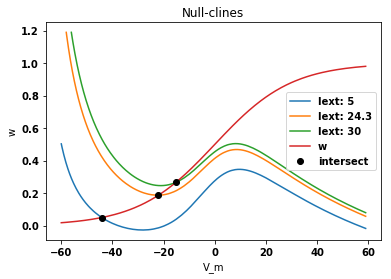

In [347]:
plt.plot(X_null_V_5,Y_null_V_5,label = 'Iext: 5')
plt.plot(X_null_V_24,Y_null_V_24,label = 'Iext: 24.3')
plt.plot(X_null_V_30,Y_null_V_30,label = 'Iext: 30')
plt.plot(X_null_w,Y_null_w,label = 'w')
plt.plot(intx_5,inty_5,'ko',label = 'intersect')
plt.plot(intx_24,inty_24,'ko')
plt.plot(intx_30,inty_30,'ko')
plt.xlabel('V_m')
plt.ylabel('w')
plt.title('Null-clines')
plt.legend()
#plt.savefig('Part1a.png')

In [148]:
X_null_w, Y_null_w = clines.getNullcline(dwdt(V,W),v_scale,w_scale)

def int_NC(I_ext):
    X_null_V_I, Y_null_V_I = NC(I_ext)
    return clines.getCrossings(X_null_V_I,Y_null_V_I,X_null_w,Y_null_w)

def eig_NC(I_ext):
    X_null_V_I, Y_null_V_I = NC(I_ext)
    x_int, y_int = int_NC(I_ext)
    J = clines.getJacobian(V,W,dVdt(V,W,I_ext),dwdt(V,W),x_int,y_int)
    J = np.squeeze(J)
    VI,DI = linalg.eig(J)
    return np.real(VI)
    

In [153]:
# If real part of all eigenvalues are negative, then ODE is stable at 
# need to repeat all above for other currents as well
print('EIG I_ext = 5: ', eig_NC(5))
print('EIG I_ext = 24.3: ',eig_NC(24.3))
print('EIG I_ext = 30: ',eig_NC(30))

EIG I_ext = 5:  [-0.396717 -0.396717]
EIG I_ext = 24.3:  [-0.09166926 -0.09166926]
EIG I_ext = 30:  [ 0.27011238  0.27011238]


In [205]:
x_int, y_int = int_NC(5)


In [202]:
#d
print('EIG I_ext = 220: ',eig_NC(220))

EIG I_ext = 220:  [-3.46224907 -0.3174134 ]


In [333]:
# simulated trajectory
# help(odeint)
I_ext = 10
x_int, y_int = int_NC(I_ext)

t = np.arange(0,100,.001)
theta = np.arange(0,181,30)


def get_traj(I_ext,theta):
    x_int, y_int = int_NC(I_ext)
    def dXdtI(XI,t):
        V, w = XI
        dV = dVdt(V,w,I_ext)
        dw = dwdt(V,w)
        return [dV,dw]
    X_all = []
    for i in range(len(theta)):
        x_intI = x_int + np.cos(theta[i]*np.pi/180)
        y_intI = y_int + np.sin(theta[i]*np.pi/180)/100
        int_cond = [x_intI[0],y_intI[0]]
        #print(int_cond)
        X1 = odeint(dXdtI,int_cond,t)
        X_all.append(X1)
    return X_all
def plt_all(X):
    n_plts = np.shape(X)[0]
    for i in range(n_plts):
        dat = np.squeeze(X[i])
        plt.plot(dat[:,0],dat[:,1])
X_all5 = get_traj(5,theta)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


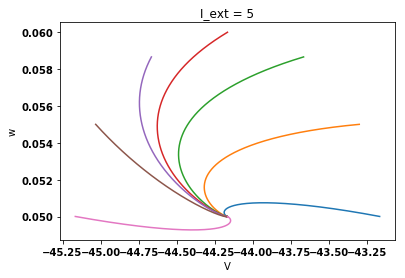

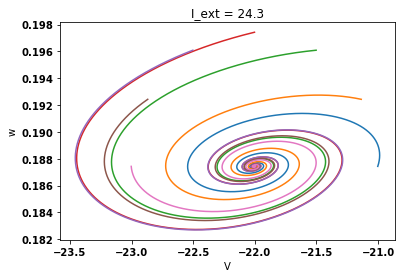

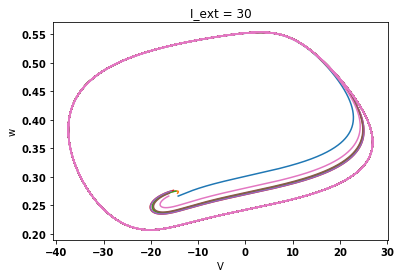

In [337]:
X_all5 = get_traj(5,theta)
plt_all(X_all5)
# plt.xlim((-80,60))
# plt.ylim((0,1.2))
plt.xlabel('V')
plt.ylabel('w')
plt.title('I_ext = 5')
plt.savefig('Part1c_1.png')
plt.show()

X_all24 = get_traj(24.3,theta)
plt_all(X_all24)
# plt.xlim((-80,60))
# plt.ylim((0,1.2))
plt.xlabel('V')
plt.ylabel('w')
plt.title('I_ext = 24.3')
plt.savefig('Part1c_2.png')
plt.show()

X_all30 = get_traj(30,theta)
plt_all(X_all30)
# plt.xlim((-80,60))
# plt.ylim((0,1.2))
plt.xlabel('V')
plt.ylabel('w')
plt.title('I_ext = 30')
plt.savefig('Part1c_3.png')
plt.show()

In [ ]:
X_all30 = get_traj(220,theta)
plt_all(X_all30)
# plt.xlim((-80,60))
# plt.ylim((0,1.2))
plt.xlabel('V')
plt.ylabel('w')
plt.title('I_ext = 220')
plt.savefig('Part1d_1.png')
plt.show()

In [362]:
v_scale = np.arange(-60,100,1)
w_scale = np.arange(-.2,2,.01)
[V,W] = np.meshgrid(v_scale,w_scale)

X_null_V_220, Y_null_V_220 = NC(220)
X_null_w, Y_null_w = clines.getNullcline(dwdt(V,W),v_scale,w_scale)
intx_220, inty_220 = int_NC(220)
print('EIG I_ext = 220: ',eig_NC(220))

EIG I_ext = 220:  [-3.46224907 -0.3174134 ]


/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


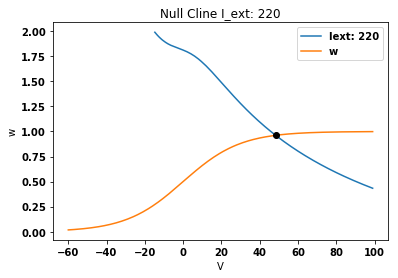

In [361]:
plt.plot(X_null_V_220,Y_null_V_220,label = 'Iext: 220')
plt.plot(X_null_w,Y_null_w,label = 'w')
plt.plot(intx_220,inty_220,'ko')
plt.title('Null Cline I_ext: 220')
plt.legend()
plt.xlabel('V')
plt.ylabel('w')
plt.savefig('part1d_2.png')

In [352]:
print(np.shape(X_null_V_30))


(280,)


In [295]:
# From week 2
# Constants
C_m  =   1.0 # membrane capacitance, in uF/cm^2
g_Ca =   1.1 # maximum conducances, in mS/cm^2
g_K  =   36
g_L  =   0.3
g_Na =   120
E_Ca = 100.0 # Nernst reversal potentials, in mV
E_K  = -12.0
E_L  = 10.613
E_Na = 115
# Channel gating kinetics
# Functions of membrane voltage
def m_infty(V): return (1.0 + sp.tanh((V + 1.0) / 15.0)) / 2.0
def w_infty(V): return (1.0 + sp.tanh(V / 30.0)) / 2.0
def tau_w(V):   return 5.0 / sp.cosh(V / 60.0)  # in ms

# Membrane currents (in uA/cm^2)
def I_Ca(V):    return g_Ca * m_infty(V) * (V - E_Ca)
def I_K(V, w):  return g_K  * w          * (V - E_K)
def I_L(V):     return g_L               * (V - E_L)

def a_m(V): return (25-V)/(10*(np.exp((25-V)/10)-1))
def b_m(V): return 4*np.exp(-V/18)
def a_h(V): return 0.07*np.exp(-V/20)
def b_h(V): return 1/(np.exp((30-V)/10)+1)
def a_n(V): return (10-V)/(100*(np.exp((10-V)/10)-1))
def b_n(V): return 0.125*np.exp(-V/80)

def dVdt_leak(V, t): return (I_ext(t) - I_L(V)) / C_m

In [371]:
def h(n): return 0.8-n
def m_inf(V): return a_m(V)/(a_m(V)+b_m(V))

def I_Na(V,n): return g_Na*m_inf(V)**3*h(n)* (V-E_Na)
def I_K(V,n): return g_K*n**4*(V-E_K)
def I_L(V): return g_L*(V-E_L)
    



/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


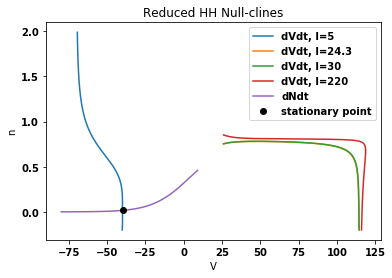

In [406]:
v_scale = np.arange(-80,160,1)
w_scale = np.arange(-.2,2,.01)
[V,W] = np.meshgrid(v_scale,w_scale)


def dVdt_HH2(V,n,I_ext): return 1/C_m*(-I_Na(V,n)-I_K(V,n)-I_L(V)+I_ext)
def dndt(V,n): return a_n(V)*(1-n)-b_n(V)*n

X_HH_V_5, Y_HH_V_5 = clines.getNullcline(dVdt_HH2(V,W,5),v_scale,w_scale)
X_HH_V_24, Y_HH_V_24 = clines.getNullcline(dVdt_HH2(V,W,24.3),v_scale,w_scale)
X_HH_V_30, Y_HH_V_30 = clines.getNullcline(dVdt_HH2(V,W,30),v_scale,w_scale)
X_HH_V_220, Y_HH_V_220 = clines.getNullcline(dVdt_HH2(V,W,220),v_scale,w_scale)

X_HH_N, Y_HH_N = clines.getNullcline(dndt(V,W),v_scale,w_scale)
X_HH_int, Y_HH_int = clines.getCrossings(X_HH_V_5,Y_HH_V_5,X_HH_N,Y_HH_N)

plt.plot(X_HH_V_5,Y_HH_V_5,label = 'dVdt, I=5')
plt.plot(X_HH_V_24,Y_HH_V_24,label = 'dVdt, I=24.3')
plt.plot(X_HH_V_30,Y_HH_V_30,label = 'dVdt, I=30')
plt.plot(X_HH_V_220,Y_HH_V_220,label = 'dVdt, I=220')
plt.plot(X_HH_N,Y_HH_N,label='dNdt')
plt.plot(X_HH_int,Y_HH_int,'ko',label='stationary point')
plt.xlabel('V')
plt.ylabel('n')
plt.title('Reduced HH Null-clines')
plt.legend()
#plt.plot(foo1,bar1)
plt.savefig('part2_1.png')

In [390]:
def get_traj_HH(I_ext,theta):
#     x_int, y_int = int_NC(I_ext)
    x_int, y_int =clines.getCrossings(X_HH_V_5,Y_HH_V_5,X_HH_N,Y_HH_N)
    def dXdtI(XI,t):
        V, w = XI
        dV = dVdt_HH2(V,w,I_ext)
        dw = dndt(V,w)
        return [dV,dw]
    X_all = []
    for i in range(len(theta)):
        x_intI = x_int + np.cos(theta[i]*np.pi/180)
        y_intI = y_int + np.sin(theta[i]*np.pi/180)/100
        int_cond = [x_intI[0],y_intI[0]]
        #print(int_cond)
        X1 = odeint(dXdtI,int_cond,t)
        X_all.append(X1)
    return X_all


/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


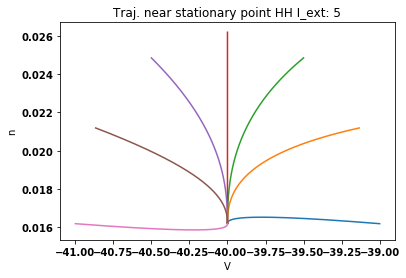

In [395]:
HH_traj = get_traj_HH(5,theta)
plt_all(HH_traj)
plt.xlabel('V')
plt.ylabel('n')
plt.title('Traj. near stationary point HH I_ext: 5')
plt.savefig('part2_2.png')

In [397]:
I_ext = 5
J = clines.getJacobian(V,W,dVdt_HH2(V,W,I_ext),dndt(V,W),X_HH_int,Y_HH_int)
J = np.squeeze(J)
VI,DI = linalg.eig(J)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide


In [399]:
VI

array([-0.4999983, -0.2094838])